In [1]:
import json
import sys
import warnings
import os

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from labellines import labelLines

# Set the working directory to the opt directory
current_dir = os.getcwd() 
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir + "/opt")

from data_process import DataProcessor # noqa: E402

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from ev_opt import EV_Opt # noqa: E402
from ev_eval import EVChargerEquityEvaluation # noqa: E402
from ev_eval_w_eqchar import EVChargerEquityEvaluationwEqChar # noqa: E402

output_dir = "../output/ev_opt_run_10000kW/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# set arial
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = ["Arial"]

# Read Data

In [2]:
k = 4

data_processor = DataProcessor()
# set demographic partition based on quantiles
kwargs = {
    "income_bins": k,
    "mud_bins": k,
    "employment_bins": k,
}
# three dfs respectively: demographic data, commute matrix, and vmt flow matrix
df1, df2, df3 = data_processor.process_demo_data(**kwargs)

# set crs to 3857 (from spherical to flat)
df1.crs = "EPSG:4326"
df1 = df1.to_crs("EPSG:3857")

# Sample Experiment Run

In [3]:
# equally assign workplace charging capacity to each CT
df1["workplace_char_capacity_kW"] = 10000 / len(df1)

char_eval = EVChargerEquityEvaluation(df1, df2, df3)

temp_inter1, temp_intra1 = char_eval.compute_equity(
    equity_indicator="char_capacity_per_capita",
    demographic_group="major_ethnicity",
    disparity_index="relative_mean_abs_dev",
)

char_eval = EVChargerEquityEvaluationwEqChar(df1, df2, df3)

temp_inter2, temp_intra2 = char_eval.compute_equity_eq_wpc(
    equity_indicator="eq_char_capacity_per_capita",
    demographic_group="major_ethnicity",
    disparity_index="relative_mean_abs_dev",
)

print(
    f"With {k} div, the inter-group and intra-group disparity were\n",
    temp_inter1,
    temp_intra1.values.mean(),
    "before optimization",
)

print(
    f"With {k} div, the inter-group and intra-group disparity were\n",
    temp_inter2,
    temp_intra2.values.mean(),
    "after installing \n10k chargers equally distributed among CTs",
)

                 eq_char_capacity_per_capita
major_ethnicity                             
Asian                               0.267558
Black                               0.288418
Other                               0.325883
White                               0.468285
major_ethnicity
Asian    0.323023
Black    0.329563
Other    0.737131
White    0.483967
dtype: float64
                 eq_total_char_capacity    popu  eq_char_capacity_per_capita
major_ethnicity                                                             
Asian                       9975.348453   38031                     0.262295
Black                      23471.156273   91828                     0.255599
Other                      34127.537458  110003                     0.310242
White                      80323.957816  207669                     0.386788
0.14744615015978643
With 4 div, the inter-group and intra-group disparity were
 0.1678818471731267 0.5039922716165881 before optimization
With 4 div, the inter-group

In [4]:
inter_4sep = 0.21387065320910212
intra_4sep = 0.5062549030512554

inter_decrease = (temp_inter1 - temp_inter2) / temp_inter1
intra_decrease = (temp_intra1.values.mean() - temp_intra2.values.mean()) / temp_intra1.values.mean()

print(
    f"Inter-group disparity decreased by {inter_decrease} \nand intra-group disparity decreased by {intra_decrease} \nafter equalizing workplace charging capacity"
)

Inter-group disparity decreased by 0.12172666287300342 
and intra-group disparity decreased by 0.0705793143782834 
after equalizing workplace charging capacity


## Sample Run 2

In [5]:
def show_other_disparity(df1, df2, df3, eval_demo_partition):
    char_eval1 = EVChargerEquityEvaluation(df1, df2, df3)

    temp_inter1, temp_intra1 = char_eval1.compute_equity(
        equity_indicator="char_capacity_per_capita",
        demographic_group=eval_demo_partition,
        disparity_index="relative_mean_abs_dev",
    )

    char_eval2 = EVChargerEquityEvaluationwEqChar(df1, df2, df3)

    temp_inter2, temp_intra2 = char_eval2.compute_equity_eq_wpc(
        equity_indicator="eq_char_capacity_per_capita",
        demographic_group=eval_demo_partition,
        disparity_index="relative_mean_abs_dev",
    )

    # print(
    #     f"With {k} div, the inter-group and intra-group disparity were\n",
    #     temp_inter1,
    #     temp_intra1.values.mean(),
    #     "before optimization",
    # )

    # print(
    #     f"With {k} div, the inter-group and intra-group disparity were\n",
    #     temp_inter2,
    #     temp_intra2.values.mean(),
    #     "after installing 10k chargers equally distributed among CTs",
    # )

    inter_decrease = (temp_inter1 - temp_inter2) / temp_inter1
    intra_decrease = (temp_intra1.values.mean() - temp_intra2.values.mean()) / temp_intra1.values.mean()

    # print(
    #     f"Inter-group disparity decreased by {inter_decrease} \nand intra-group disparity decreased by {intra_decrease} \nafter equalizing workplace charging capacity"
    # )

    return temp_inter1 - temp_inter2, temp_intra1.values.mean() - temp_intra2.values.mean()


In [6]:
# read results
df_result_val = pd.read_csv(output_dir + "df_result_val.csv")
char_kW = 10000
demo_group = "income_level"

slice_all = df_result_val[
    df_result_val["equity_indicator"] == "char_capacity_per_capita"][
    df_result_val["demographic_group"] == "income_level"][
    df_result_val["disparity_index"] == "relative_mean_abs_dev"][
    df_result_val["max_add_capacity"] == char_kW][
    df_result_val["weight_between"] == 0.5]

df1["workplace_char_capacity_kW"] = [float(i) for i in slice_all.charger_capacity_wp.values[0].replace("[", "").replace("]", "").split(", ")]

eval_demo_partition = "income_level"

char_eval1 = EVChargerEquityEvaluation(df1, df2, df3)

# compute equity before optimization
temp_inter1, temp_intra1 = char_eval1.compute_equity(
    equity_indicator="char_capacity_per_capita",
    demographic_group=eval_demo_partition,
    disparity_index="relative_mean_abs_dev",
)

char_eval2 = EVChargerEquityEvaluationwEqChar(df1, df2, df3)

temp_inter2, temp_intra2 = char_eval2.compute_equity_eq_wpc(
    equity_indicator="eq_char_capacity_per_capita",
    demographic_group=eval_demo_partition,
    disparity_index="relative_mean_abs_dev",
)

print(
    f"With {k} div, the inter-group and intra-group disparity were\n",
    temp_inter1,
    temp_intra1.values.mean(),
    "before optimization",
)

print(
    f"With {k} div, the inter-group and intra-group disparity were\n",
    temp_inter2,
    temp_intra2.values.mean(),
    "after installing 10k chargers based on optimization results",
)

With 4 div, the inter-group and intra-group disparity were
 0.21387065320910212 0.5062549030512554 before optimization
With 4 div, the inter-group and intra-group disparity were
 0.1626629803053649 0.46200392002482416 after installing 10k chargers based on optimization results


In [7]:
inter_4sep = 0.21387065320910212
intra_4sep = 0.5062549030512554

inter_decrease = (temp_inter1 - temp_inter2) / temp_inter1
intra_decrease = (temp_intra1.values.mean() - temp_intra2.values.mean()) / temp_intra1.values.mean()

print(
    f"Inter-group disparity decreased by {inter_decrease} \nand intra-group disparity decreased by {intra_decrease} \nafter equalizing workplace charging capacity"
)

Inter-group disparity decreased by 0.23943291019769447 
and intra-group disparity decreased by 0.08740850263321026 
after equalizing workplace charging capacity


## Sample run 4x4 with equal distribution

In [8]:
demographic_group_list = [
    "income_level",
    "mud_level",
    "employment_level",
    "major_ethnicity",
]

char_kW = 10000 

In [9]:
df1["workplace_char_capacity_kW"] = char_kW / len(df1)
df_result_equal = pd.DataFrame(columns=["income", "mud_rate", "employment", "ethnicity"])
df_result_equal["income"] = show_other_disparity(df1, df2, df3, "income_level")
df_result_equal["mud_rate"] = show_other_disparity(df1, df2, df3, "mud_level")
df_result_equal["employment"] = show_other_disparity(df1, df2, df3, "employment_level")
df_result_equal["ethnicity"] = show_other_disparity(df1, df2, df3, "major_ethnicity")
df_result_equal.index = ["inter_decrease_equal", "intra_decrease_equal"]

df1["workplace_char_capacity_kW"] = char_kW * (df1.popu/df1.popu.sum())
df_result_popu_weighted = pd.DataFrame(columns=["income", "mud_rate", "employment", "ethnicity"])
df_result_popu_weighted["income"] = show_other_disparity(df1, df2, df3, "income_level")
df_result_popu_weighted["mud_rate"] = show_other_disparity(df1, df2, df3, "mud_level")
df_result_popu_weighted["employment"] = show_other_disparity(df1, df2, df3, "employment_level")
df_result_popu_weighted["ethnicity"] = show_other_disparity(df1, df2, df3, "major_ethnicity")
df_result_popu_weighted.index = ["inter_decrease_equal", "intra_decrease_equal"]

df1["workplace_char_capacity_kW"] = char_kW * (df1.VKT_flow_in_km/df1.VKT_flow_in_km.sum())
df_result_vkt_weighted = pd.DataFrame(columns=["income", "mud_rate", "employment", "ethnicity"])
df_result_vkt_weighted["income"] = show_other_disparity(df1, df2, df3, "income_level")
df_result_vkt_weighted["mud_rate"] = show_other_disparity(df1, df2, df3, "mud_level")
df_result_vkt_weighted["employment"] = show_other_disparity(df1, df2, df3, "employment_level")
df_result_vkt_weighted["ethnicity"] = show_other_disparity(df1, df2, df3, "major_ethnicity")
df_result_vkt_weighted.index = ["inter_decrease_equal", "intra_decrease_equal"]

df1["workplace_char_capacity_kW"] = char_kW * (df1.veh_num/df1.veh_num.sum())
df_result_veh_weighted = pd.DataFrame(columns=["income", "mud_rate", "employment", "ethnicity"])
df_result_veh_weighted["income"] = show_other_disparity(df1, df2, df3, "income_level")
df_result_veh_weighted["mud_rate"] = show_other_disparity(df1, df2, df3, "mud_level")
df_result_veh_weighted["employment"] = show_other_disparity(df1, df2, df3, "employment_level")
df_result_veh_weighted["ethnicity"] = show_other_disparity(df1, df2, df3, "major_ethnicity")
df_result_veh_weighted.index = ["inter_decrease_equal", "intra_decrease_equal"]

                 eq_char_capacity_per_capita
major_ethnicity                             
Asian                               0.267558
Black                               0.288418
Other                               0.325883
White                               0.468285
major_ethnicity
Asian    0.323023
Black    0.329563
Other    0.737131
White    0.483967
dtype: float64
                 eq_total_char_capacity    popu  eq_char_capacity_per_capita
major_ethnicity                                                             
Asian                       9975.348453   38031                     0.262295
Black                      23471.156273   91828                     0.255599
Other                      34127.537458  110003                     0.310242
White                      80323.957816  207669                     0.386788
0.14744615015978643
                 eq_char_capacity_per_capita
major_ethnicity                             
Asian                               0.265504
Black     

In [10]:
show_other_disparity(df1, df2, df3, "income_level")

(np.float64(0.01611463359656018), np.float64(0.03014971057802862))

In [11]:
df_result_opt_inter = pd.DataFrame()
df_result_opt_intra = pd.DataFrame()


for demo_group in demographic_group_list:
    slice_all = df_result_val[
        df_result_val["equity_indicator"] == "char_capacity_per_capita"][
        df_result_val["demographic_group"] == demo_group][
        df_result_val["disparity_index"] == "relative_mean_abs_dev"][
        df_result_val["max_add_capacity"] == char_kW][
        df_result_val["weight_between"] == 0.5]

    df1["workplace_char_capacity_kW"] = [float(i) for i in slice_all.charger_capacity_wp.values[0].replace("[", "").replace("]", "").split(", ")]

    inter_income, intra_income = show_other_disparity(df1, df2, df3, "income_level")
    inter_mud, intra_mud = show_other_disparity(df1, df2, df3, "mud_level")
    inter_employment, intra_employment = show_other_disparity(df1, df2, df3, "employment_level")
    inter_eth, intra_eth = show_other_disparity(df1, df2, df3, "major_ethnicity")

    df_result_opt_inter[demo_group] = [inter_income, inter_mud, inter_employment, inter_eth]
    df_result_opt_intra[demo_group] = [intra_income, intra_mud, intra_employment, intra_eth]

df_result_opt_inter.index = ["income_rmad_decrease", "mud_rmad_decrease", "employment_rmad_decrease", "eth_rmad_decrease"]
df_result_opt_intra.index = ["income_rmad_decrease", "mud_rmad_decrease", "employment_rmad_decrease", "eth_rmad_decrease"]
df_result_opt_inter.columns = ["opt_income", "opt_mud", "opt_employment", "opt_ethnicity"]
df_result_opt_intra.columns = ["opt_income", "opt_mud", "opt_employment", "opt_ethnicity"]


                 eq_char_capacity_per_capita
major_ethnicity                             
Asian                               0.273089
Black                               0.295197
Other                               0.339147
White                               0.452951
major_ethnicity
Asian    0.258681
Black    0.293583
Other    0.695419
White    0.496799
dtype: float64
                 eq_total_char_capacity    popu  eq_char_capacity_per_capita
major_ethnicity                                                             
Asian                      10226.732202   38031                     0.268905
Black                      24184.441849   91828                     0.263367
Other                      35819.539390  110003                     0.325623
White                      77667.286559  207669                     0.373996
0.13584561244198035
                 eq_char_capacity_per_capita
major_ethnicity                             
Asian                               0.266858
Black     

In [12]:
df_result_opt_inter["equal_dist"] = df_result_equal.iloc[0].values
df_result_opt_intra["equal_dist"] = df_result_equal.iloc[1].values
df_result_opt_inter["popu_weighted"] = df_result_popu_weighted.iloc[0].values
df_result_opt_intra["popu_weighted"] = df_result_popu_weighted.iloc[1].values
df_result_opt_inter["vkt_weighted"] = df_result_vkt_weighted.iloc[0].values
df_result_opt_intra["vkt_weighted"] = df_result_vkt_weighted.iloc[1].values
df_result_opt_inter["veh_weighted"] = df_result_veh_weighted.iloc[0].values
df_result_opt_intra["veh_weighted"] = df_result_veh_weighted.iloc[1].values

In [13]:
df_result_opt_inter

,opt_income,opt_mud,opt_employment,opt_ethnicity,equal_dist,popu_weighted,vkt_weighted,veh_weighted
income_rmad_decrease,0.051208,0.047682,0.035799,0.046361,0.016635,0.018086,0.013858,0.016115
mud_rmad_decrease,0.047424,0.051769,0.035069,0.033252,0.018300,0.020302,0.014643,0.018103
employment_rmad_decrease,0.026601,0.024828,0.030497,0.018110,0.011006,0.013037,0.008244,0.009939
eth_rmad_decrease,0.032036,0.030810,0.019959,0.067719,0.020436,0.017848,0.016468,0.019421


In [14]:
df_result_opt_inter.index = ["Income", "MUD", "Employ.", "Ethnicity"]
df_result_opt_inter.columns = ["Income", "MUD", "Employ.", "Ethnicity", "Eq. Distr", "Popu. Weighted", "VKT Distr", "Veh. Weighted"]

df_result_opt_intra.index = ["Income", "MUD", "Employ.", "Ethnicity"]
df_result_opt_intra.columns = ["Income", "MUD", "Employ.", "Ethnicity", "Eq. Distr", "Popu. Weighted", "VKT Distr", "Veh. Weighted"]

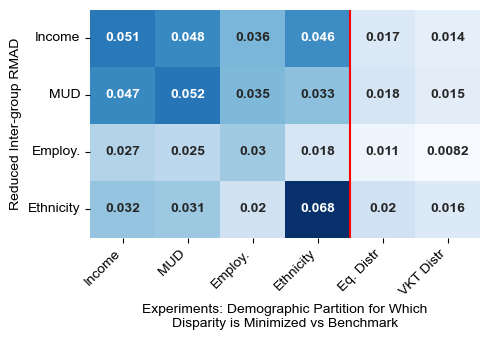

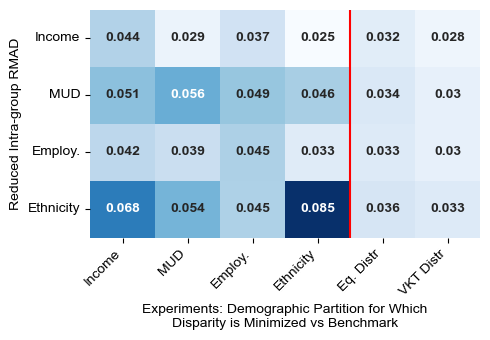

In [15]:
#heatmap 
#make it pretty
df_result_opt_inter = df_result_opt_inter[["Income", "MUD", "Employ.", "Ethnicity", "Eq. Distr", "VKT Distr"]]
df_result_opt_intra = df_result_opt_intra[["Income", "MUD", "Employ.", "Ethnicity", "Eq. Distr", "VKT Distr"]]
fig, ax = plt.subplots(figsize=(5, 3.5))
sns.heatmap(df_result_opt_inter, annot=True, cmap="Blues", cbar=False, ax=ax, annot_kws={"fontweight": "bold"})

ax.set_xlabel("Experiments: Demographic Partition for Which\nDisparity is Minimized vs Benchmark")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment="right")
ax.set_ylabel("Reduced Inter-group RMAD")
ax.vlines([4], *ax.get_ylim(), colors="red")


plt.tight_layout()
plt.savefig(output_dir + "heatmap_inter_group_disp.pdf", dpi=300)

fig, ax = plt.subplots(figsize=(5, 3.5))
sns.heatmap(df_result_opt_intra, annot=True, cmap="Blues", cbar=False, ax=ax, annot_kws={"fontweight": "bold"})
# red text in xlabel
ax.set_xlabel("Experiments: Demographic Partition for Which\nDisparity is Minimized vs Benchmark")

ax.vlines([4], *ax.get_ylim(), colors="red")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment="right")
ax.set_ylabel("Reduced Intra-group RMAD")
plt.tight_layout()
plt.savefig(output_dir + "heatmap_intra_group_disp.pdf", dpi=300)


In [16]:
df_result_opt_inter.to_csv(output_dir + "df_result_opt_inter.csv")
df_result_opt_intra.to_csv(output_dir + "df_result_opt_intra.csv")

In [17]:
df_result_opt_inter_opt = (df_result_opt_inter.values[:, :4].sum() + df_result_opt_intra.values[:, :4].sum())/8
df_result_opt_inter_bench = (df_result_opt_inter.values[:, 4:].sum() + df_result_opt_intra.values[:, 4:].sum())/4

df_result_opt_inter_opt/df_result_opt_inter_bench

np.float64(1.7869503733292709)

In [18]:
slice_all = df_result_val[
        df_result_val["equity_indicator"] == "char_capacity_per_capita"][
        df_result_val["demographic_group"] == demographic_group_list[1]][
        df_result_val["disparity_index"] == "relative_mean_abs_dev"][
        df_result_val["max_add_capacity"] == char_kW][
        df_result_val["weight_between"] == 0.5]

df1["workplace_char_capacity_kW"] = [float(i) for i in slice_all.charger_capacity_wp.values[0].replace("[", "").replace("]", "").split(", ")]

char_eval1 = EVChargerEquityEvaluation(df1, df2, df3)

temp_inter1, temp_intra1 = char_eval1.compute_equity(
    equity_indicator="char_capacity_per_capita",
    demographic_group="employment_level",
    disparity_index="relative_mean_abs_dev",
)

char_eval2 = EVChargerEquityEvaluationwEqChar(df1, df2, df3)

temp_inter2, temp_intra2 = char_eval2.compute_equity_eq_wpc(
    equity_indicator="eq_char_capacity_per_capita",
    demographic_group="employment_level",
    disparity_index="relative_mean_abs_dev",
)

temp_inter1, temp_inter2, temp_intra1.values.mean(), temp_intra2.values.mean()

(np.float64(0.159833081338974),
 np.float64(0.1350055234317771),
 np.float64(0.4609013896890578),
 np.float64(0.4217330844225081))

# More analysis

In [19]:
equity_indicator_list = [
    # "char_per_capita",
    # "char_per_veh",
    # "char_per_VKT_out",
    "char_capacity_per_capita",
    "char_capacity_per_car",
    "char_capacity_per_VKT_out",
]
demographic_group_list = [
    "income_level",
    "mud_level",
    "employment_level",
    "major_ethnicity",
]
disparity_index_list = [
    "relative_mean_abs_dev"
]  # "relative_mean_abs_dev", "gini_coefficient", "mean_abs_dev", "theil_index"
disparity_index_name = "RMAD"
df_result = pd.DataFrame(
    columns=[
        "equity_indicator",
        "demographic_group",
        "disparity_index",
        "inter_value",
        "intra_value",
    ]
)

for equity_indicator in equity_indicator_list:
    for demographic_group in demographic_group_list:
        for disparity_index in disparity_index_list:
            inter_dis, intra_dis = char_eval.compute_equity(equity_indicator, demographic_group, disparity_index)
            df_result.loc[len(df_result)] = [
                equity_indicator,
                demographic_group,
                disparity_index,
                inter_dis,
                intra_dis.values,
            ]

In [20]:
df_result  # .groupby(["equity_indicator", "demographic_group"]).mean()

,equity_indicator,demographic_group,disparity_index,inter_value,intra_value
0,char_capacity_per_capita,income_level,relative_mean_abs_dev,0.136837,"[0.6016156046483057, 0.48977368254135006, 0.24..."
1,char_capacity_per_capita,mud_level,relative_mean_abs_dev,0.143267,"[0.44236421485335337, 0.4261955992431314, 0.32..."
2,char_capacity_per_capita,employment_level,relative_mean_abs_dev,0.128310,"[0.5770025441038408, 0.3720955456118566, 0.311..."
3,char_capacity_per_capita,major_ethnicity,relative_mean_abs_dev,0.137687,"[0.37209029346462963, 0.3889239744289203, 0.75..."
4,char_capacity_per_car,income_level,relative_mean_abs_dev,0.150027,"[0.5233776070748061, 0.7364325437688625, 0.159..."
5,char_capacity_per_car,mud_level,relative_mean_abs_dev,0.149529,"[0.5952279573414152, 0.4486353528569128, 0.319..."
6,char_capacity_per_car,employment_level,relative_mean_abs_dev,0.100815,"[0.6383410574167573, 0.4510112942966979, 0.208..."
7,char_capacity_per_car,major_ethnicity,relative_mean_abs_dev,0.186636,"[0.3339309355766423, 0.3520534877266015, 0.833..."
8,char_capacity_per_VKT_out,income_level,relative_mean_abs_dev,0.117952,"[0.6531649488355507, 0.5688997010119322, 0.511..."
9,char_capacity_per_VKT_out,mud_level,relative_mean_abs_dev,0.305975,"[0.5120961344339485, 0.5579362648939156, 0.336..."


In [21]:
df_result[df_result["demographic_group"] == "income_level"]

,equity_indicator,demographic_group,disparity_index,inter_value,intra_value
0,char_capacity_per_capita,income_level,relative_mean_abs_dev,0.136837,"[0.6016156046483057, 0.48977368254135006, 0.24..."
4,char_capacity_per_car,income_level,relative_mean_abs_dev,0.150027,"[0.5233776070748061, 0.7364325437688625, 0.159..."
8,char_capacity_per_VKT_out,income_level,relative_mean_abs_dev,0.117952,"[0.6531649488355507, 0.5688997010119322, 0.511..."


In [22]:
# separate inter_value into two or four columns
df_result = df_result.join(pd.DataFrame(df_result["intra_value"].tolist()).add_prefix("intra_value_"))
df_result

,equity_indicator,demographic_group,disparity_index,inter_value,intra_value,intra_value_0,intra_value_1,intra_value_2,intra_value_3
0,char_capacity_per_capita,income_level,relative_mean_abs_dev,0.136837,"[0.6016156046483057, 0.48977368254135006, 0.24...",0.601616,0.489774,0.247837,0.756404
1,char_capacity_per_capita,mud_level,relative_mean_abs_dev,0.143267,"[0.44236421485335337, 0.4261955992431314, 0.32...",0.442364,0.426196,0.327602,0.672607
2,char_capacity_per_capita,employment_level,relative_mean_abs_dev,0.128310,"[0.5770025441038408, 0.3720955456118566, 0.311...",0.577003,0.372096,0.311284,0.648049
3,char_capacity_per_capita,major_ethnicity,relative_mean_abs_dev,0.137687,"[0.37209029346462963, 0.3889239744289203, 0.75...",0.372090,0.388924,0.756543,0.504716
4,char_capacity_per_car,income_level,relative_mean_abs_dev,0.150027,"[0.5233776070748061, 0.7364325437688625, 0.159...",0.523378,0.736433,0.159669,0.556395
5,char_capacity_per_car,mud_level,relative_mean_abs_dev,0.149529,"[0.5952279573414152, 0.4486353528569128, 0.319...",0.595228,0.448635,0.319558,0.689886
6,char_capacity_per_car,employment_level,relative_mean_abs_dev,0.100815,"[0.6383410574167573, 0.4510112942966979, 0.208...",0.638341,0.451011,0.208552,0.628874
7,char_capacity_per_car,major_ethnicity,relative_mean_abs_dev,0.186636,"[0.3339309355766423, 0.3520534877266015, 0.833...",0.333931,0.352053,0.833111,0.393848
8,char_capacity_per_VKT_out,income_level,relative_mean_abs_dev,0.117952,"[0.6531649488355507, 0.5688997010119322, 0.511...",0.653165,0.568900,0.511268,0.794039
9,char_capacity_per_VKT_out,mud_level,relative_mean_abs_dev,0.305975,"[0.5120961344339485, 0.5579362648939156, 0.336...",0.512096,0.557936,0.336854,0.689190
